In [1]:
import torch
import os
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import numpy as np
import random
import time

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Config

In [2]:
mnist_config = {
    'input_size': 784,
    'batch_size': 64,
    'lr': 0.001,
    'hidden_layers': 2,
    'hidden_size': 512,
    'epochs': 5,
    'log_interval': 10, # log every 10 batches
    'output_size': 10
}

sst_config = {
    'batch_size': 64,
    'lr': 0.001,
    'hidden_layers': 2,
    'hidden_size': 256,
    'epochs': 2,
    'log_interval': 10,
    'output_size': 2
}

# Utils

# Dataset Classes

## SST

In [3]:
class SSTDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_type='train', suffix='tsv', vocab=None, top_k=0, remove_stopwords=False):
        self.datapath = os.path.join(data_dir, data_type + '.' + suffix)
        self.data_type = data_type
        self.sentences = []
        self.labels = []

        with open(self.datapath) as data_f:
            for line in data_f:
                sentence, label = line.strip().split('\t')
                self.sentences.append(sentence)
                self.labels.append(label)
        self.sentences = self.sentences[1:]
        self.labels = self.labels[1:]
        if vocab is None:
            self.vocab = self.build_vocab()
        else:
            self.vocab = vocab
        if top_k > 0:
            self.vocab = self.vocab[:top_k]
        if remove_stopwords:
            self.vocab = self.remove_stopwords()
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        # add OOV token
        if vocab is None:
            self.vocab.append('<OOV>')
            self.word2idx['<OOV>'] = len(self.vocab) - 1
            self.idx2word[len(self.vocab) - 1] = '<OOV>'
            
    def remove_stopwords(self):
        # remove stopwords obtained from nltk
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        return [word for word in self.vocab if word not in stop_words]

    def __len__(self):
        return len(self.sentences)

    def one_hot_encode(self, word):
        vector = torch.zeros(len(self.vocab))
        if word in self.word2idx:
            vector[self.word2idx[word]] += 1
        else:
            vector[self.word2idx['<OOV>']] += 1
        return vector
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoded_sentence = torch.sum(torch.stack([self.one_hot_encode(word) for word in sentence.split()]), dim=0)
        encoded_label = torch.tensor(int(label)) # 0: negative, 1: positive
        return encoded_sentence, encoded_label

    def build_vocab(self):
        vocab = set()
        for sentence in self.sentences:
            for word in sentence.split():
                vocab.add(word)
        return sorted(list(vocab))


In [4]:
sst_train_dataset = SSTDataset(data_dir='SST-2', data_type='train')
for i in range(1):
    print(sst_train_dataset.vocab)
    print(sst_train_dataset[i])

['!', '!?', '#', '$', '&', "'", "''", "'30s", "'40s", "'50s", "'53", "'60s", "'70s", "'80s", "'90s", "'d", "'em", "'ll", "'m", "'n", "'n'", "'re", "'s", "'til", "'ve", '(', ')', '*', '***', '****', '+', ',', '-', '--', '.', '...', '/', '1', '1.8', '1/2', '10', '10,000', '10-course', '10-year', '10-year-old', '100', '100-minute', '101', '103-minute', '105', '10th', '10th-grade', '11', '110', '112-minute', '12-year-old', '120', '127', '129-minute', '12th', '13', '13th', '14-year-old', '140', '146', '15', '15-year', '15th', '163', '168-minute', '170', '1790', '18', '18-year-old', '1899', '19', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '19th-century', '2', '2,500', '2-day', '2/3', '20', '20-car', '2000', '2001', '2002', '20th', '21/2', '21st', '22', '22-year

In [5]:
sst_train_dataset = SSTDataset(data_dir='SST-2', data_type='train')
sst_dev_dataset = SSTDataset(data_dir='SST-2', data_type='dev', vocab=sst_train_dataset.vocab)

## MNIST 

In [6]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_type='train', suffix='csv', transforms=None):
        self.datapath = os.path.join(data_dir, f'mnist_{data_type}.{suffix}')
        self.labels = []
        self.data = []
        self.transforms = transforms
        
        with open(self.datapath) as data_f:
            line_cnt = 0
            for line in data_f:
                if line_cnt > 0:
                    data = line.strip().split(',')
                    self.labels.append(data[0])
                    self.data.append(torch.tensor([float(dp) for dp in data[1:]]))
                line_cnt += 1
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        # normalize the data
        data = (data - torch.mean(data)) / torch.std(data)
        if self.transforms is not None:
            # reconstruct to image and do transforms
            data = data.reshape(1, 28, 28)
            data = self.transforms(data)
            # flatten
            data = data.reshape(-1)
        return data, torch.tensor(int(label))

/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vincenthuang/Development/on-device-ml/on-device-ml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update t

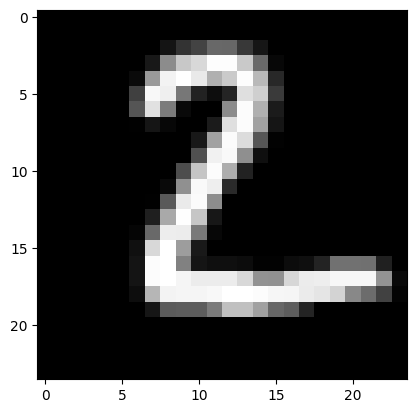

In [7]:
# visualize one example
from torchvision import transforms

test_transform = transforms.Resize((24, 24))
test_mnist_dataset = MNISTDataset(data_dir='MNIST', data_type='test', transforms=test_transform)
dp = test_mnist_dataset[0]
plt.imshow(dp[0].reshape(24, 24), cmap='gray')

# Dataloader

In [8]:
sst_dataloader = torch.utils.data.DataLoader(
    dataset=sst_train_dataset,
    batch_size=sst_config['batch_size'],
    shuffle=True
)
sst_dev_dataloader = torch.utils.data.DataLoader(
    dataset=sst_dev_dataset,
    batch_size=sst_config['batch_size'],
    shuffle=False
)
mnist_dataloader = torch.utils.data.DataLoader(
    dataset=MNISTDataset(data_dir='MNIST', data_type='train'),
    batch_size=mnist_config['batch_size'],
    shuffle=True
)
mnist_valid_dataloader = torch.utils.data.DataLoader(
    dataset=MNISTDataset(data_dir='MNIST', data_type='test'),
    batch_size=mnist_config['batch_size'],
    shuffle=False
)

In [9]:
for i, (data, label) in enumerate(mnist_dataloader):
    print(data.shape)
    print(label.shape)
    break

torch.Size([64, 784])
torch.Size([64])


In [10]:
for i, (data, label) in enumerate(sst_dataloader):
    print(data.shape)
    print(label.shape)
    break

torch.Size([64, 14817])
torch.Size([64])


# Model

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.output_size = output_size
        self.total_flops = 0
        self.layers = torch.nn.ModuleList()
        for layer_idx in range(self.num_hidden_layers):
            if layer_idx == 0:
                self.layers.append(torch.nn.Linear(self.input_size, self.hidden_size))
                self.total_flops += self.input_size * self.hidden_size
            else:
                self.layers.append(torch.nn.Linear(self.hidden_size, self.hidden_size))
                self.total_flops += self.hidden_size * self.hidden_size
            self.layers.append(torch.nn.ReLU())
            self.total_flops += self.hidden_size
        self.layers.append(torch.nn.Linear(self.hidden_size, self.output_size))
        self.total_flops += self.hidden_size * self.output_size
        self.softmax = torch.nn.Softmax(dim=1)
        self.total_flops += self.output_size * np.log2(self.output_size)
    
    def forward(self, x):
        # x: (batch_size, input_size)
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x) 
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Trainer

In [12]:
class Trainer:
    def __init__(self, model, train_dl, valid_dl, config):
        self.model = model
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.config = config
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config['lr'])
        self.training_time = 0
        self.training_time_per_epoch = []
        self.total_inference_time = 0
        self.inference_time = []
        self.avg_inference_time_per_epoch = []

    def train(self):
        start = time.time()
        for epoch in range(self.config['epochs']):
            start_time = time.time()
            self.train_one_epoch()
            end_time = time.time()
            self.training_time_per_epoch.append(end_time - start_time)
        end = time.time()
        self.training_time = end - start
            
    def train_one_epoch(self):
        batch_bar = tqdm.tqdm(total=len(self.train_dl), dynamic_ncols=True, leave=True, position=0, desc='Train', ncols=5)
        num_correct = 0
        total_loss = 0
        total_inference_epoch = 0

        for idx, (train_data, train_label) in enumerate(self.train_dl):
            unit_num_correct, unit_total_loss, batch_inference_time = self.train_one_batch(train_data, train_label)
            total_inference_epoch += batch_inference_time
            num_correct += unit_num_correct
            total_loss += unit_total_loss
            batch_bar.set_postfix(
                acc = f"{100 * num_correct / (self.config['batch_size'] * (idx + 1)):.4f}",
                loss = f"{total_loss / (self.config['batch_size'] * (idx + 1)):.4f}",
                num_correct = f"{num_correct}",
                lr = f"{self.optimizer.param_groups[0]['lr']:.4f}"
            )
            batch_bar.update()
        
        self.avg_inference_time_per_epoch.append(total_inference_epoch / len(self.train_dl.dataset))
        batch_bar.close()
        self.validate()
        
    def train_one_batch(self, train_data, train_label):
        self.optimizer.zero_grad()
        inference_start = time.time()
        output = self.model(train_data)
        inference_end = time.time()
        self.total_inference_time += inference_end - inference_start
        # l2 regularization
        # loss = self.criterion(output, train_label) - 0.001 * torch.norm(self.model.layers[0].weight, p=2) 
        loss = self.criterion(output, train_label)
        num_correct = torch.sum(torch.argmax(output, dim=1) == train_label).item()
        total_loss = float(loss.item())
        loss.backward()
        self.optimizer.step()
        
        return num_correct, total_loss, inference_end - inference_start

    def validate(self):
        # report accuracy
        correct_count = 0
        for _, (valid_data, valid_label) in enumerate(self.valid_dl):
            output = self.model(valid_data)
            pred = torch.argmax(output, dim=1) # (batch_size)
            correct_count += torch.sum(pred == valid_label).item()
        acc = correct_count / len(self.valid_dl.dataset)
        print(f'Validation Accuracy: {correct_count / len(self.valid_dl.dataset)}')
        return acc
    
    def report(self):
        # report training time, inference time for each sample
        print(f'Number of parameters: {self.model.count_parameters()}')
        print(f'Total number of FLOPs: {self.model.total_flops}')
        print(f'Total number of trainable parameters: {self.model.count_parameters()}')
        print(f'Average training time per epoch: {np.mean(self.training_time_per_epoch)} seconds')
        print(f'Training time: {self.training_time} seconds')
        print(f'Average inference time per sample: {self.total_inference_time / (self.config["epochs"] * len(self.train_dl.dataset))} seconds')

# Train the MNIST Model

In [13]:
mnist_model=MLP(input_size=mnist_config['input_size'], hidden_size=mnist_config['hidden_size'], num_hidden_layers=mnist_config['hidden_layers'], output_size=mnist_config['output_size'])

In [14]:
mnist_trainer = Trainer(
    model=mnist_model,
    train_dl=mnist_dataloader,
    valid_dl=mnist_valid_dataloader,
    config=mnist_config
)

mnist_trainer.train()
mnist_trainer.report()

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9413941394139413


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9536953695369537


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9537953795379538


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.95009500950095


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9496949694969496
Number of parameters: 669706
Total number of FLOPs: 669729.2192809489
Total number of trainable parameters: 669706
Average training time per epoch: 5.57005352973938 seconds
Training time: 27.850277185440063 seconds
Average inference time per sample: 9.134324837268203e-06 seconds


# Train the SST Model

In [15]:
sst_model = MLP(input_size=len(sst_train_dataset.vocab), 
                hidden_size=sst_config['hidden_size'], 
                num_hidden_layers=sst_config['hidden_layers'], 
                output_size=sst_config['output_size'])

sst_trainer = Trainer(
    model=sst_model,
    train_dl=sst_dataloader,
    valid_dl=sst_dev_dataloader,
    config=sst_config
)
sst_trainer.train()

Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8004587155963303


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8153669724770642


In [16]:
sst_trainer.report()

Number of parameters: 3859714
Total number of FLOPs: 3859714.0
Total number of trainable parameters: 3859714
Average training time per epoch: 33.04215395450592 seconds
Training time: 66.08431792259216 seconds
Average inference time per sample: 5.074824718192195e-05 seconds


# Experiments 3: Average Training Time and Inference Latency

In [17]:
def initialize_trainer(training_config, train_dl, valid_dl):
    model = MLP(input_size=training_config['input_size'], hidden_size=training_config['hidden_size'], num_hidden_layers=training_config['hidden_layers'], output_size=training_config['output_size'])
    trainer = Trainer(
        model=model,
        train_dl=train_dl,
        valid_dl=valid_dl,
        config=training_config
    )
    return trainer

In [18]:
# increase the number of epochs to 15
exp3_mnist_config = mnist_config.copy()
exp3_mnist_config['epochs'] = 10
exp3_mnist_trainer = initialize_trainer(exp3_mnist_config, mnist_dataloader, mnist_valid_dataloader)
exp3_mnist_trainer.train()
exp3_mnist_trainer.report()

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9408940894089409


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9453945394539454


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9460946094609461


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9597959795979598


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9474947494749475


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9596959695969597


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9460946094609461


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9641964196419642


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9616961696169617


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9583958395839584
Number of parameters: 669706
Total number of FLOPs: 669729.2192809489
Total number of trainable parameters: 669706
Average training time per epoch: 5.3007842063903805 seconds
Training time: 53.00785708427429 seconds
Average inference time per sample: 9.646691724291189e-06 seconds


In [19]:
# do the same for sst
exp3_sst_config = sst_config.copy()
exp3_sst_config['epochs'] = 10
exp3_sst_config['input_size'] = len(sst_train_dataset.vocab)
exp3_sst_trainer = initialize_trainer(exp3_sst_config, sst_dataloader, sst_dev_dataloader)
exp3_sst_trainer.train()
exp3_sst_trainer.report()

Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7970183486238532


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7958715596330275


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.801605504587156


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8211009174311926


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8027522935779816


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7993119266055045


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8038990825688074


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.801605504587156


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7993119266055045


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8038990825688074
Number of parameters: 3859714
Total number of FLOPs: 3859714.0
Total number of trainable parameters: 3859714
Average training time per epoch: 37.151298475265506 seconds
Training time: 371.51299691200256 seconds
Average inference time per sample: 5.236654430722962e-05 seconds


In [20]:
# MNIST average training time and inference latency
# plot the training time and inference latency
def plot_training_time(trainers, config):
    legends = []
    plt.figure(figsize=(10, 5))
    for trainer_name in trainers:
        trainer = trainers[trainer_name]
        plt.plot(np.arange(config['epochs']), trainer.training_time_per_epoch)
        legends.append(trainer_name)
    plt.xlabel('Epoch')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time per Epoch')
    plt.legend(legends)
    plt.show()
    
def plot_inference_time_per_epoch(trainers, config):
    legends = []
    plt.figure(figsize=(10, 5))

    for trainer_name in trainers:
        trainer = trainers[trainer_name]
        plt.plot(np.arange(config['epochs']), trainer.avg_inference_time_per_epoch)

        legends.append(trainer_name)

    plt.xlabel('Epoch')
    plt.ylabel('Inference Time per Sample (s)')
    plt.title('Inference Time per Sample per Epoch')
    plt.legend(legends)
    plt.show()

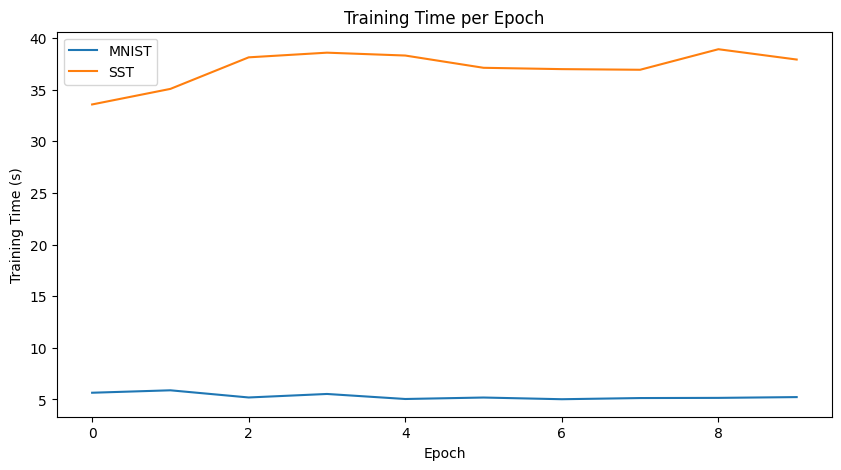

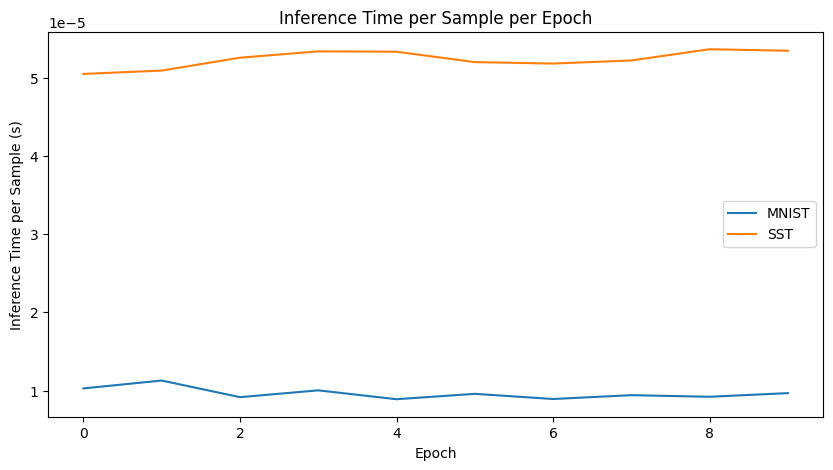

In [21]:
trainers = {
    'MNIST': exp3_mnist_trainer,
    'SST': exp3_sst_trainer
}

plot_training_time(trainers, exp3_mnist_config)
plot_inference_time_per_epoch(trainers, exp3_sst_config)


In [23]:
exp3_sst_trainer.model.total_flops

3859714.0

# Experiment 6, 7: Varying depth and width

In [24]:
def run_experiment67(config, train_dl, valid_dl, param_type, values):
    accs = []
    flops = []
    latencies = []
    for idx, value in enumerate(values):
        print(f'running experiment {idx + 1} with {param_type} = {value}')
        config[param_type] = value
        trainer = initialize_trainer(config, train_dl, valid_dl)
        trainer.train()
        acc = trainer.validate()
        accs.append(acc)
        flops.append(trainer.model.total_flops)
        latencies.append(trainer.total_inference_time / (config['epochs'] * len(train_dl.dataset)))
    return accs, flops, latencies

def plot_results(model_names, accs, flops, latencies, exp=6):
    # use model names as legends
    # plot point plots
    for i in range(len(model_names)):
        plt.figure(figsize=(10, 5))
        # point plots
        plt.scatter(flops[i], accs[i])
        plt.xlabel('FLOPs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs. FLOPs for {model_names[i]}')
        plt.legend()
        plt.show()
        plt.savefig(f'exp{exp}_{model_names[i]}_acc_flops.png')
        
        
    for i in range(len(model_names)):
        plt.figure(figsize=(10, 5))
        plt.scatter(latencies[i], accs[i])
        plt.xlabel('Inference Latency (s)')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs. Inference Latency for {model_names[i]}')
        plt.legend()
        plt.show()
        plt.savefig(f'exp{exp}_{model_names[i]}_acc_latency.png')
    
    for i in range(len(model_names)):
        plt.figure(figsize=(10, 5))
        plt.scatter(flops[i], latencies[i])
        plt.xlabel('FLOPs')
        plt.ylabel('Inference Latency (s)')
        plt.title(f'Inference Latency vs. FLOPs for {model_names[i]}')
        plt.legend()
        plt.show()
        plt.savefig(f'exp{exp}_{model_names[i]}_flops_latency.png')


In [25]:
hidden_sizes = [32, 64, 128, 256, 512, 1024, 2048]
num_layers = [1, 2, 3, 4, 5, 6, 7, 8]

In [26]:
# run for mnist num layers
exp6_mnist_config = mnist_config.copy()
exp6_mnist_config['epochs'] = 3
exp6_mnist_accs, exp6_mnist_flops, exp6_mnist_latencies = run_experiment67(exp6_mnist_config, mnist_dataloader, mnist_valid_dataloader, 'hidden_layers', num_layers)

running experiment 1 with hidden_layers = 1


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9517951795179518


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9682968296829683


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9690969096909691
Validation Accuracy: 0.9690969096909691
running experiment 2 with hidden_layers = 2


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.946894689468947


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9420942094209421


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9532953295329533
Validation Accuracy: 0.9532953295329533
running experiment 3 with hidden_layers = 3


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9211921192119212


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9398939893989399


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9007900790079008
Validation Accuracy: 0.9007900790079008
running experiment 4 with hidden_layers = 4


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8775877587758776


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.692969296929693


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.7346734673467347
Validation Accuracy: 0.7346734673467347
running experiment 5 with hidden_layers = 5


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.7694769476947695


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.47104710471047107


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.1467146714671467
Validation Accuracy: 0.1467146714671467
running experiment 6 with hidden_layers = 6


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.1565156515651565


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.11681168116811681


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.11681168116811681
Validation Accuracy: 0.11681168116811681
running experiment 7 with hidden_layers = 7


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.14291429142914291


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.10271027102710271


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.10271027102710271
Validation Accuracy: 0.10271027102710271
running experiment 8 with hidden_layers = 8


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.09820982098209821


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.09820982098209821


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.09820982098209821
Validation Accuracy: 0.09820982098209821


In [28]:
# run for sst num layers
exp6_sst_config = sst_config.copy()
exp6_sst_config['epochs'] = 2
exp6_sst_config['input_size'] = len(sst_train_dataset.vocab)
exp6_sst_accs, exp6_sst_flops, exp6_sst_latencies = run_experiment67(exp6_sst_config, sst_dataloader, sst_dev_dataloader, 'hidden_layers', num_layers)

running experiment 1 with hidden_layers = 1


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8096330275229358


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.801605504587156
Validation Accuracy: 0.801605504587156
running experiment 2 with hidden_layers = 2


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7912844036697247


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8119266055045872
Validation Accuracy: 0.8119266055045872
running experiment 3 with hidden_layers = 3


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7970183486238532


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7935779816513762
Validation Accuracy: 0.7935779816513762
running experiment 4 with hidden_layers = 4


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8038990825688074


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8165137614678899
Validation Accuracy: 0.8165137614678899
running experiment 5 with hidden_layers = 5


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7935779816513762


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7706422018348624
Validation Accuracy: 0.7706422018348624
running experiment 6 with hidden_layers = 6


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7912844036697247


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8027522935779816
Validation Accuracy: 0.8027522935779816
running experiment 7 with hidden_layers = 7


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7970183486238532


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7924311926605505
Validation Accuracy: 0.7924311926605505
running experiment 8 with hidden_layers = 8


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7935779816513762


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7763761467889908
Validation Accuracy: 0.7763761467889908


In [29]:
exp6_sst_accs

[0.801605504587156,
 0.8119266055045872,
 0.7935779816513762,
 0.8165137614678899,
 0.7706422018348624,
 0.8027522935779816,
 0.7924311926605505,
 0.7763761467889908]

In [30]:
exp6_sst_latencies

[5.619044710928568e-05,
 5.734750062639222e-05,
 5.726689554187941e-05,
 5.754610607464009e-05,
 5.9806514146338625e-05,
 6.326133030383337e-05,
 6.161927628172705e-05,
 6.0078945490410834e-05]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


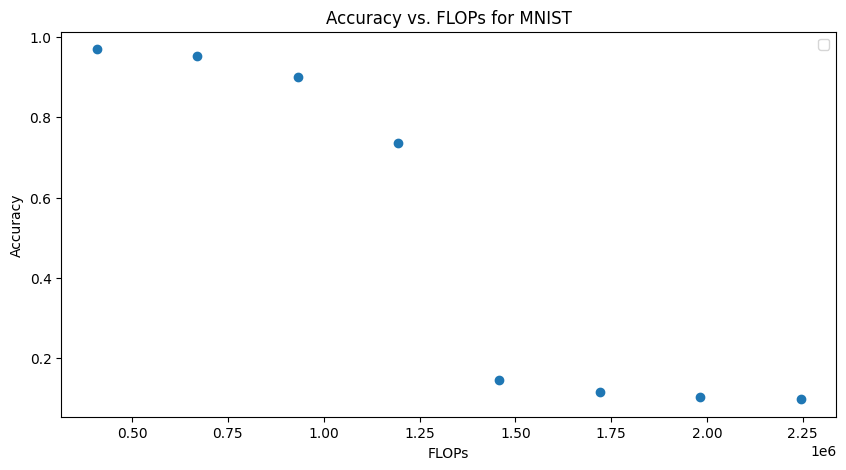

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

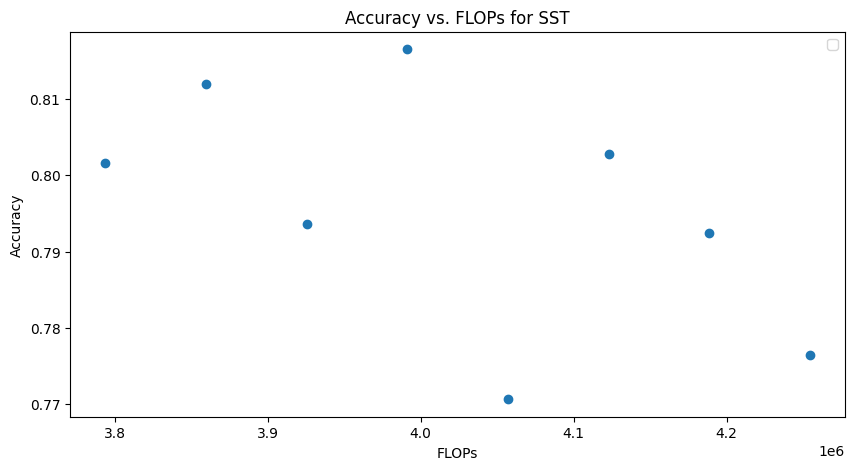

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

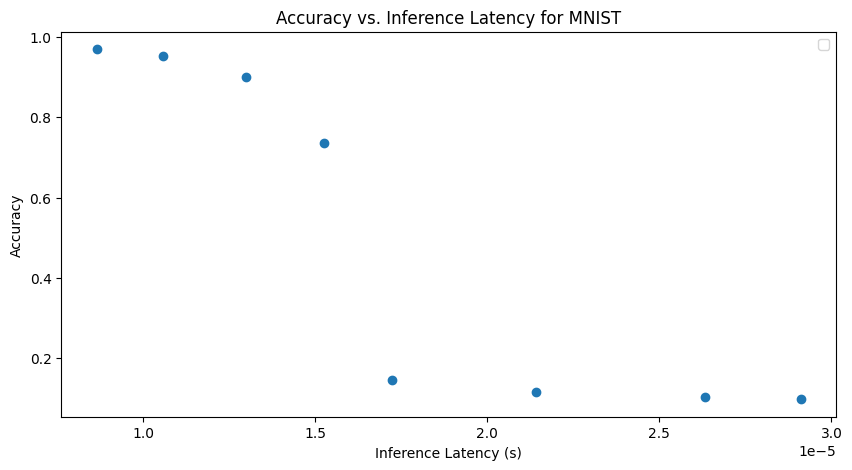

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

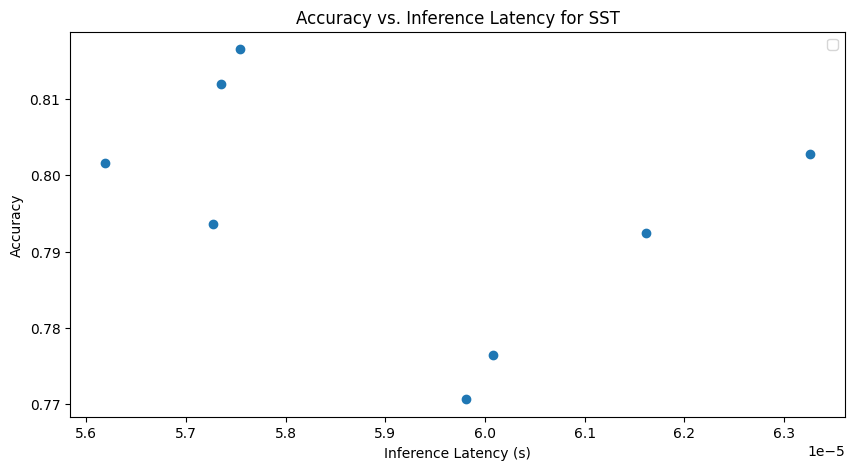

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

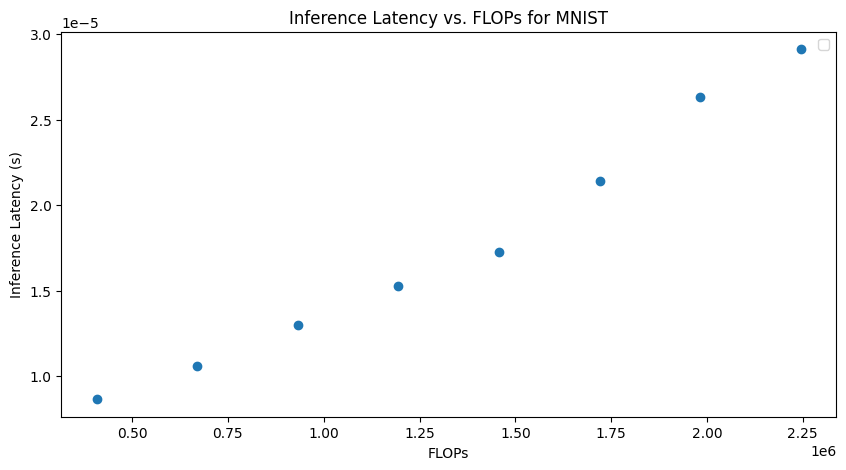

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

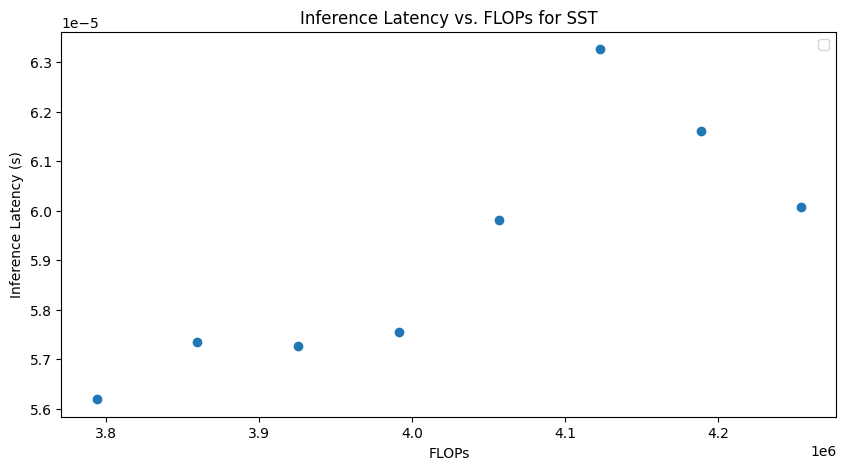

<Figure size 640x480 with 0 Axes>

In [31]:
plot_results(
    model_names=['MNIST', 'SST'],
    accs=[exp6_mnist_accs, exp6_sst_accs],
    flops=[exp6_mnist_flops, exp6_sst_flops],
    latencies=[exp6_mnist_latencies, exp6_sst_latencies]
)

In [32]:
# run for mnist hidden size
exp7_mnist_config = mnist_config.copy()
exp7_mnist_config['epochs'] = 3
exp7_mnist_accs, exp7_mnist_flops, exp7_mnist_latencies = run_experiment67(exp7_mnist_config, mnist_dataloader, mnist_valid_dataloader, 'hidden_size', hidden_sizes)

running experiment 1 with hidden_size = 32


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8502850285028503


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8648864886488649


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.93999399939994
Validation Accuracy: 0.93999399939994
running experiment 2 with hidden_size = 64


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9371937193719372


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9486948694869487


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9578957895789579
Validation Accuracy: 0.9578957895789579
running experiment 3 with hidden_size = 128


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9458945894589459


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.957995799579958


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9606960696069607
Validation Accuracy: 0.9606960696069607
running experiment 4 with hidden_size = 256


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9523952395239524


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.956995699569957


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.957995799579958
Validation Accuracy: 0.957995799579958
running experiment 5 with hidden_size = 512


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9484948494849484


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9476947694769476


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.960996099609961
Validation Accuracy: 0.960996099609961
running experiment 6 with hidden_size = 1024


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9316931693169317


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.918091809180918


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9314931493149315
Validation Accuracy: 0.9314931493149315
running experiment 7 with hidden_size = 2048


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8518851885188519


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8640864086408641


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8891889188918892
Validation Accuracy: 0.8891889188918892


In [33]:
# run for sst hidden size
exp7_sst_config = sst_config.copy()
exp7_sst_config['epochs'] = 2
exp7_sst_config['input_size'] = len(sst_train_dataset.vocab)
exp7_sst_accs, exp7_sst_flops, exp7_sst_latencies = run_experiment67(exp7_sst_config, sst_dataloader, sst_dev_dataloader, 'hidden_size', hidden_sizes)

running experiment 1 with hidden_size = 32


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7981651376146789


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8061926605504587
Validation Accuracy: 0.8061926605504587
running experiment 2 with hidden_size = 64


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8038990825688074


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7958715596330275
Validation Accuracy: 0.7958715596330275
running experiment 3 with hidden_size = 128


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8130733944954128


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8084862385321101
Validation Accuracy: 0.8084862385321101
running experiment 4 with hidden_size = 256


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7958715596330275


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8096330275229358
Validation Accuracy: 0.8096330275229358
running experiment 5 with hidden_size = 512


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7981651376146789


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.805045871559633
Validation Accuracy: 0.805045871559633
running experiment 6 with hidden_size = 1024


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.823394495412844


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7878440366972477
Validation Accuracy: 0.7878440366972477
running experiment 7 with hidden_size = 2048


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8096330275229358


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7889908256880734
Validation Accuracy: 0.7889908256880734


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


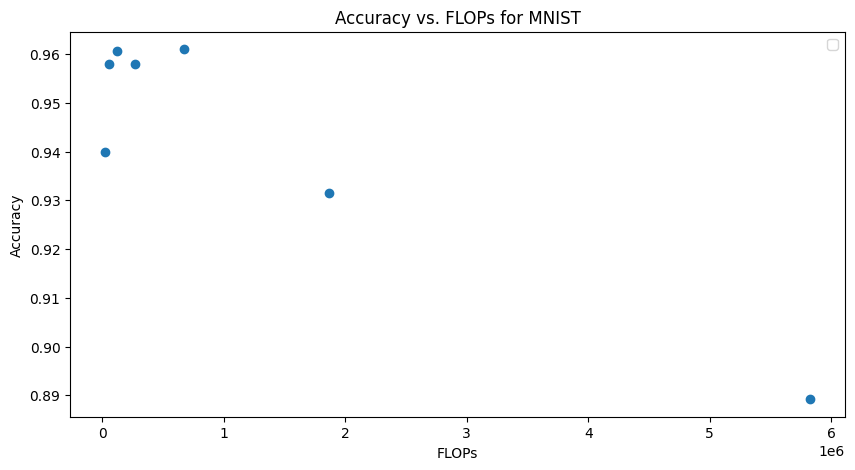

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

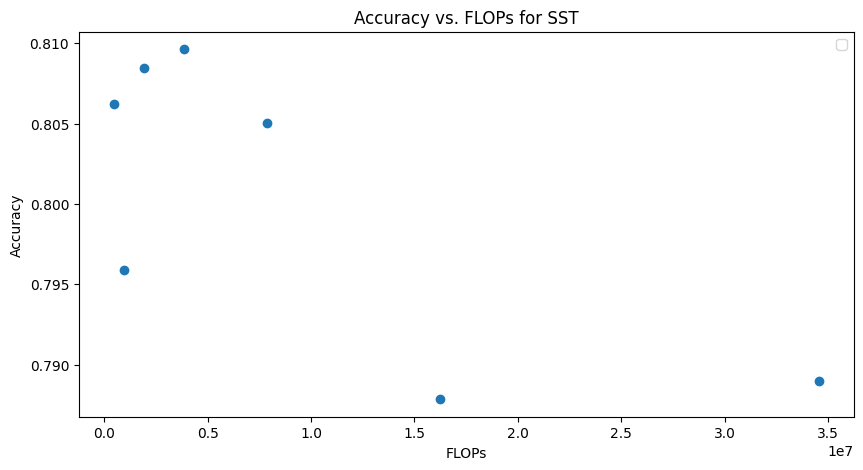

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

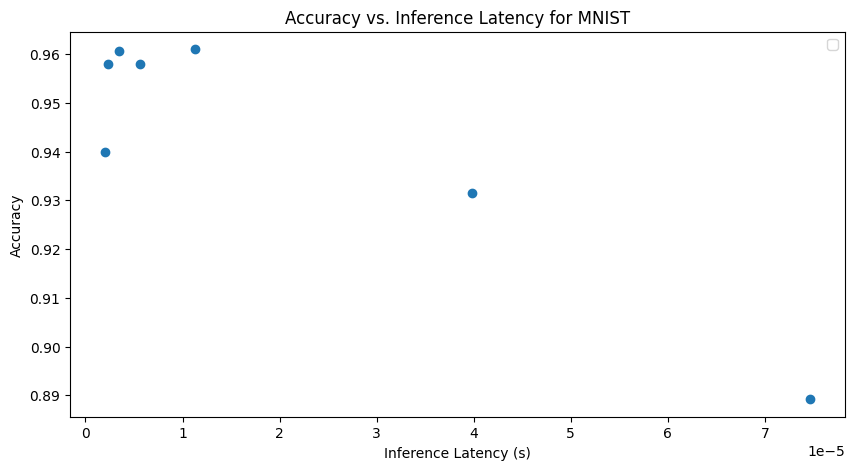

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

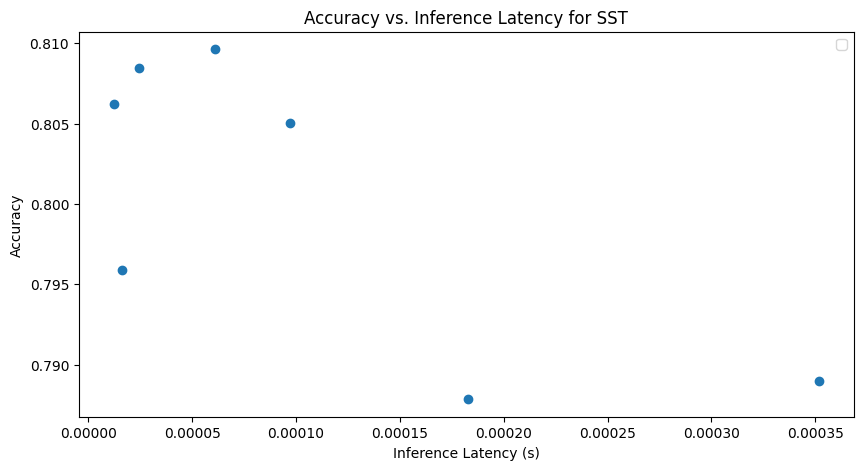

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

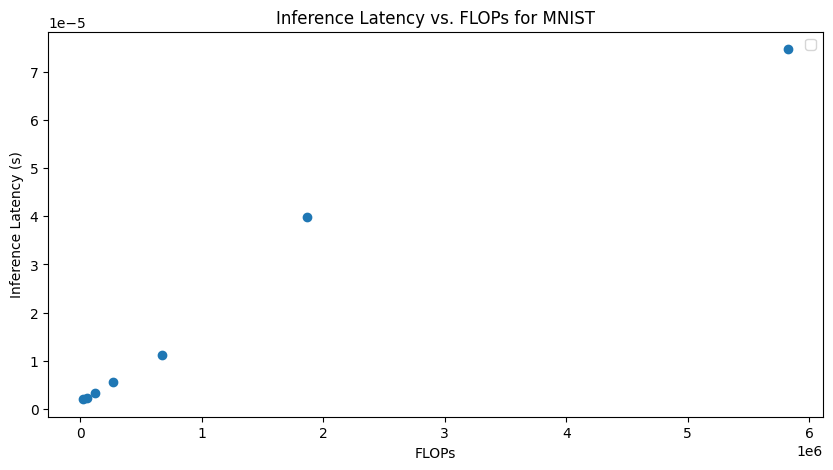

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

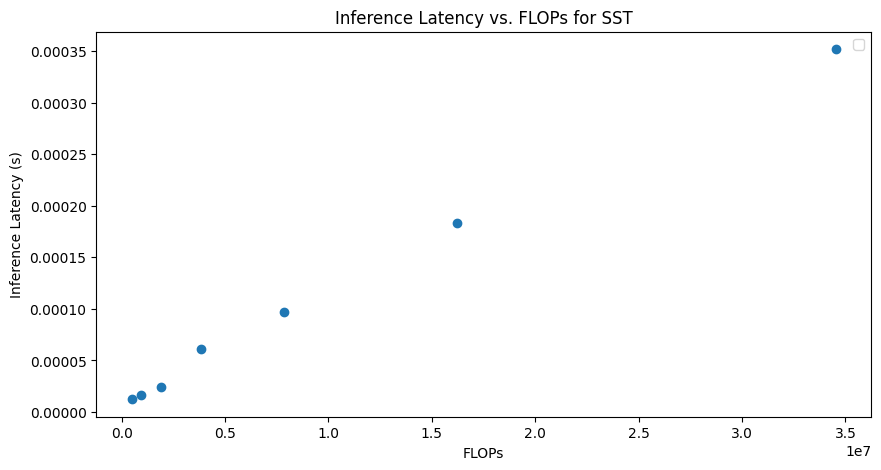

<Figure size 640x480 with 0 Axes>

In [34]:
plot_results(
    model_names=['MNIST', 'SST'],
    accs=[exp7_mnist_accs, exp7_sst_accs],
    flops=[exp7_mnist_flops, exp7_sst_flops],
    latencies=[exp7_mnist_latencies, exp7_sst_latencies],
    exp=7
)


# Experiment 8: Varying input size for MNIST

In [35]:
from torchvision import transforms

In [36]:
# downsample by resizing the image to a smaller size -> downsample by 2, 4, 8
# add the transforms in the dataloader
# define transforms
downsample_transforms = {
    'downsample-28': transforms.Resize((28, 28)),
    'downsample-24': transforms.Resize((24, 24)),
    'downsample-20': transforms.Resize((20, 20)),
    'downsample-16': transforms.Resize((16, 16)),
    'downsample-12': transforms.Resize((12, 12)),
    'downsample-8': transforms.Resize((8, 8)),
}

In [37]:
mnist_exp8_dataloaders = {}

for transform_name in downsample_transforms:
    mnist_exp8_dataloaders[transform_name] = {'train': torch.utils.data.DataLoader(
        dataset=MNISTDataset(data_dir='MNIST', data_type='train',
                             transforms=downsample_transforms[transform_name]),
        batch_size=mnist_config['batch_size'],
        shuffle=True
    ), 
    'valid': torch.utils.data.DataLoader(
        dataset=MNISTDataset(data_dir='MNIST', data_type='test',
                             transforms=downsample_transforms[transform_name]),
        batch_size=mnist_config['batch_size'],
        shuffle=False
    )}

downsample-28
torch.Size([64, 784])


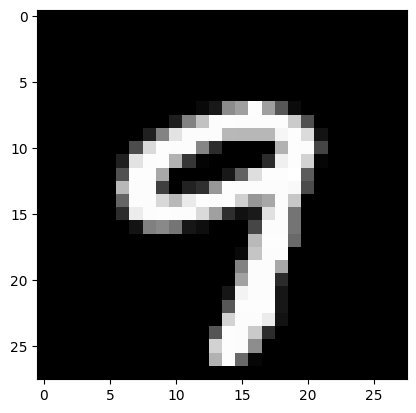

downsample-24
torch.Size([64, 576])


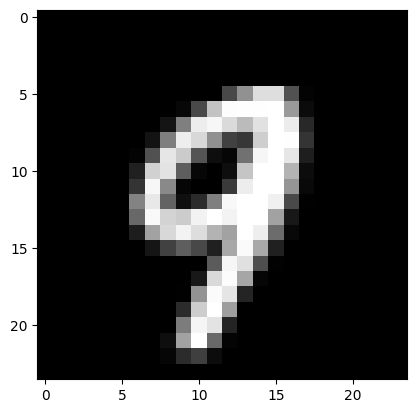

downsample-20
torch.Size([64, 400])


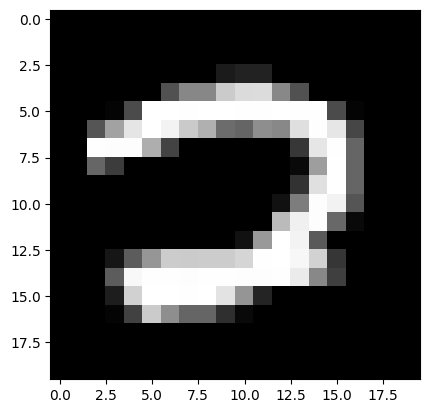

downsample-16
torch.Size([64, 256])


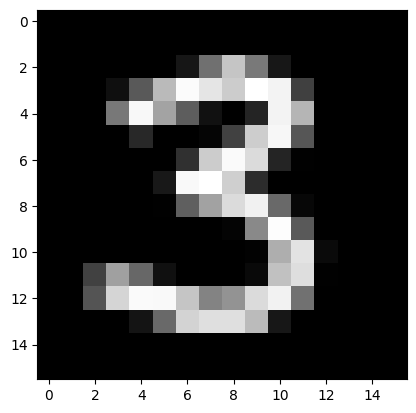

downsample-12
torch.Size([64, 144])


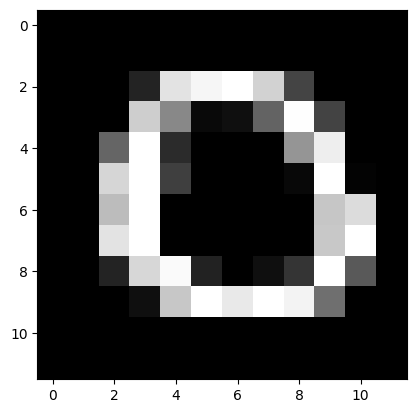

downsample-8
torch.Size([64, 64])


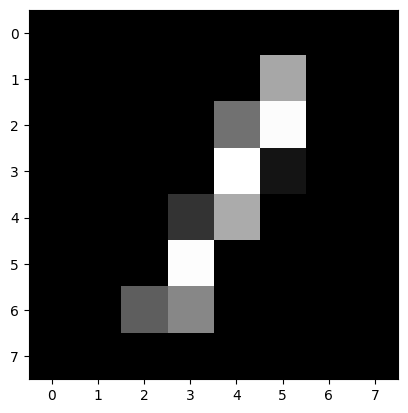

In [38]:
# print a sample of the downsampled images
for transform_name in downsample_transforms:
    print(transform_name)
    for i, (data, label) in enumerate(mnist_exp8_dataloaders[transform_name]['train']):
        print(data.shape)
        plt.imshow(data[0].reshape(int(transform_name.split('-')[1]), int(transform_name.split('-')[1])), cmap='gray')
        plt.show()
        break

In [39]:
def run_experiment8(config, dls, downsample_transforms):
    accs = []
    flops = []
    latencies = []
    for transform_name in downsample_transforms:
        print(f'Training with transform {transform_name}')
        config['input_size'] = int(transform_name.split('-')[1]) ** 2
        trainer = initialize_trainer(config, 
                                     dls[transform_name]['train'], 
                                     dls[transform_name]['valid'])
        trainer.train()
        acc = trainer.validate()
        accs.append(acc)
        flops.append(trainer.model.total_flops)
        latencies.append(trainer.total_inference_time / (config['epochs'] * len(dls[transform_name]['train'].dataset)))
    return accs, flops, latencies

In [40]:
/# train the models using different transforms
exp8_mnist_config = mnist_config.copy()
exp8_mnist_config['epochs'] = 3
exp8_mnist_accs, exp8_mnist_flops, exp8_mnist_latencies = run_experiment8(exp8_mnist_config, mnist_exp8_dataloaders, downsample_transforms)

Training with transform downsample-28


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9453945394539454


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9522952295229523


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9556955695569557
Validation Accuracy: 0.9556955695569557
Training with transform downsample-24


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9444944494449445


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9457945794579458


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9590959095909591
Validation Accuracy: 0.9590959095909591
Training with transform downsample-20


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9395939593959396


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9532953295329533


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9594959495949595
Validation Accuracy: 0.9594959495949595
Training with transform downsample-16


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.95009500950095


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9577957795779578


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.954995499549955
Validation Accuracy: 0.954995499549955
Training with transform downsample-12


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9425942594259425


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.957995799579958


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9627962796279628
Validation Accuracy: 0.9627962796279628
Training with transform downsample-8


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8957895789578958


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9183918391839184


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9246924692469247
Validation Accuracy: 0.9246924692469247


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


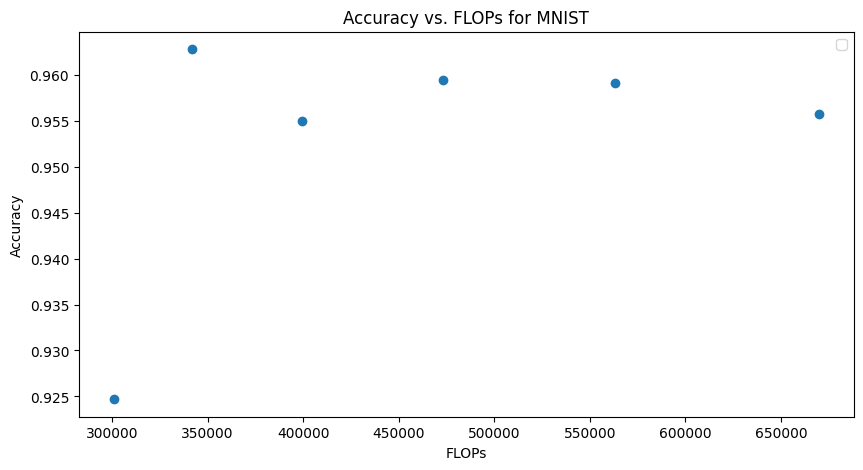

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

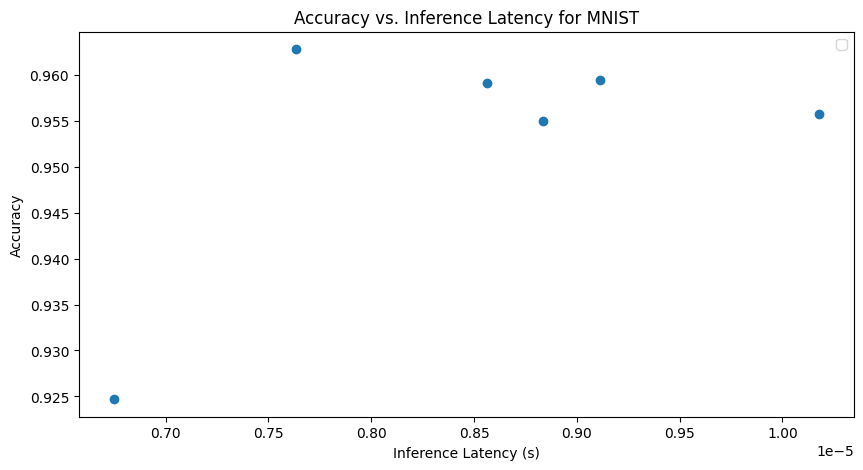

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

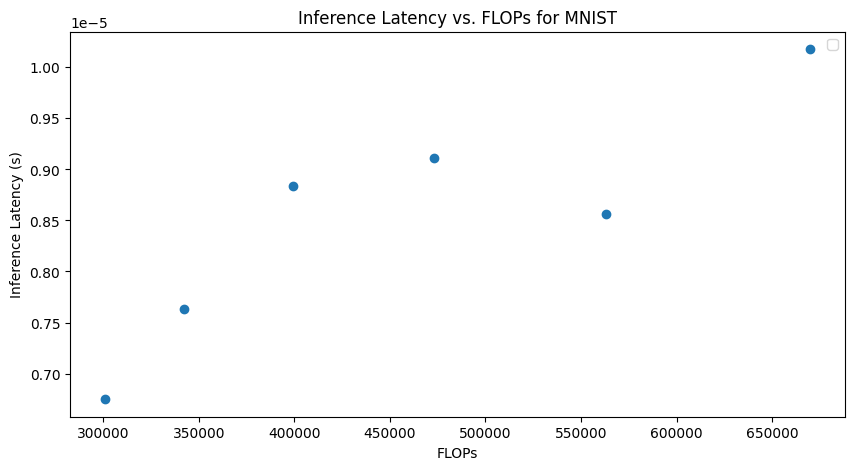

<Figure size 640x480 with 0 Axes>

In [41]:
plot_results(
    model_names=['MNIST'],
    accs=[exp8_mnist_accs],
    flops=[exp8_mnist_flops],
    latencies=[exp8_mnist_latencies],
    exp=8
)

In [42]:
# use cropping instead and do the same thing
# define transforms
crop_transforms = {
    'crop-28': transforms.CenterCrop((28, 28)),
    'crop-24': transforms.CenterCrop((24, 24)),
    'crop-20': transforms.CenterCrop((20, 20)),
    'crop-16': transforms.CenterCrop((16, 16)),
    'crop-12': transforms.CenterCrop((12, 12))
}

In [43]:
mnist_exp9_dataloaders = {}

for transform_name in crop_transforms:
    mnist_exp9_dataloaders[transform_name] = {'train': torch.utils.data.DataLoader(
        dataset=MNISTDataset(data_dir='MNIST', data_type='train',
                             transforms=crop_transforms[transform_name]),
        batch_size=mnist_config['batch_size'],
        shuffle=True
    ), 
    'valid': torch.utils.data.DataLoader(
        dataset=MNISTDataset(data_dir='MNIST', data_type='test',
                             transforms=crop_transforms[transform_name]),
        batch_size=mnist_config['batch_size'],
        shuffle=False
    )}

In [44]:
exp9_config = mnist_config.copy()
exp9_config['epochs'] = 3
exp9_mnist_accs, exp9_mnist_flops, exp9_mnist_latencies = run_experiment8(exp9_config, mnist_exp9_dataloaders, crop_transforms)

Training with transform crop-28


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9502950295029503


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9533953395339534


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9586958695869587
Validation Accuracy: 0.9586958695869587
Training with transform crop-24


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9422942294229423


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9517951795179518


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9563956395639563
Validation Accuracy: 0.9563956395639563
Training with transform crop-20


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9537953795379538


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9541954195419542


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9622962296229624
Validation Accuracy: 0.9622962296229624
Training with transform crop-16


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8517851785178517


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9535953595359536


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9581958195819582
Validation Accuracy: 0.9581958195819582
Training with transform crop-12


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.8955895589558955


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9305930593059306


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.930993099309931
Validation Accuracy: 0.930993099309931


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


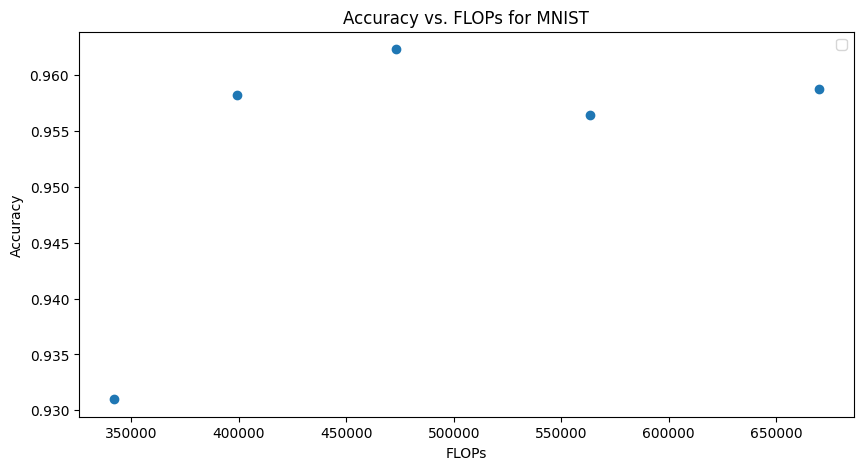

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

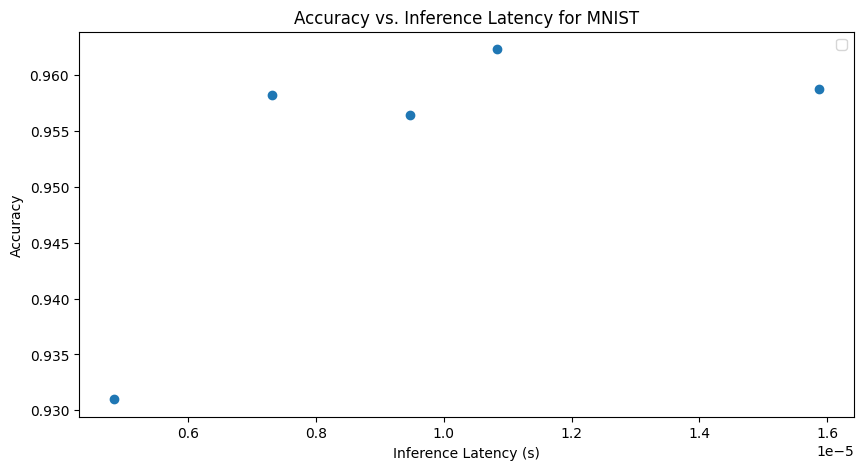

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

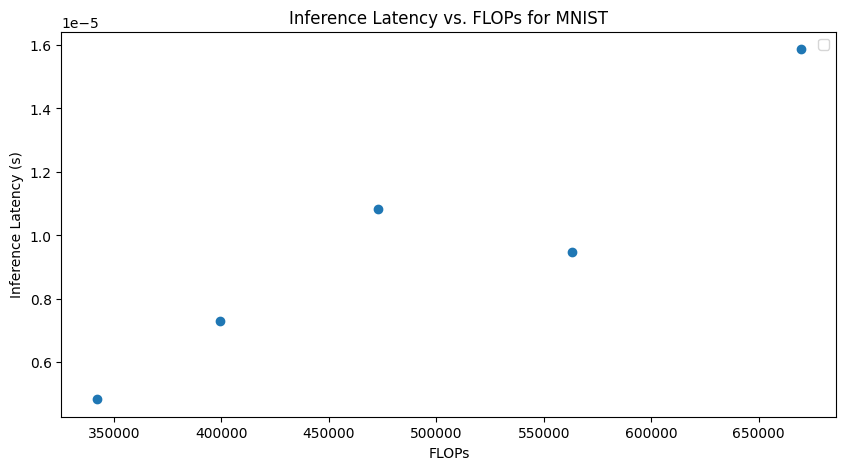

<Figure size 640x480 with 0 Axes>

In [45]:
plot_results(
    model_names=['MNIST'],
    accs=[exp9_mnist_accs],
    flops=[exp9_mnist_flops],
    latencies=[exp9_mnist_latencies],
    exp=9
)

# Experiment 10: Varying input size for SST

In [46]:
# top k most frequency words as vocabulary
sst_exp10_dataloaders = {}
original_vocab_size = len(sst_train_dataset.vocab)
for k_percentage in [0.5, 0.65, 0.8, 0.95]:
    k = int(original_vocab_size * k_percentage)
    train_ds = SSTDataset(data_dir='SST-2', data_type='train', top_k=k)
    sst_exp10_dataloaders[f'top_k-{k_percentage}'] = {'train': torch.utils.data.DataLoader(
        dataset=train_ds,
        batch_size=sst_config['batch_size'],
        shuffle=True
    ), 
    'valid': torch.utils.data.DataLoader(
        dataset=SSTDataset(data_dir='SST-2', data_type='dev', vocab=train_ds.vocab),
        batch_size=sst_config['batch_size'],
        shuffle=False
    )}

In [47]:
def run_experiment10(config, dls, downsample_transforms):
    accs = []
    flops = []
    latencies = []
    for transform_name in downsample_transforms:
        print(f'Training with top {transform_name} vocabulary')
        curr_vocab_size = len(dls[transform_name]['train'].dataset.vocab)
        config['input_size'] = curr_vocab_size
        trainer = initialize_trainer(config, 
                                     dls[transform_name]['train'], 
                                     dls[transform_name]['valid'])
        trainer.train()
        acc = trainer.validate()
        accs.append(acc)
        flops.append(trainer.model.total_flops)
        latencies.append(trainer.total_inference_time / (config['epochs'] * len(dls[transform_name]['train'].dataset)))
    return accs, flops, latencies

In [48]:
# train the models using different vocab size
exp10_sst_config = sst_config.copy()
exp10_sst_config['epochs'] = 2
exp10_sst_config['input_size'] = len(sst_train_dataset.vocab)

exp10_sst_accs, exp10_sst_flops, exp10_sst_latencies = run_experiment10(exp10_sst_config, sst_exp10_dataloaders, sst_exp10_dataloaders.keys())

Training with top top_k-0.5 vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7362385321100917


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7201834862385321
Validation Accuracy: 0.7201834862385321
Training with top top_k-0.65 vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7924311926605505


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7912844036697247
Validation Accuracy: 0.7912844036697247
Training with top top_k-0.8 vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7752293577981652


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7752293577981652
Validation Accuracy: 0.7752293577981652
Training with top top_k-0.95 vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7821100917431193


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.801605504587156
Validation Accuracy: 0.801605504587156


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


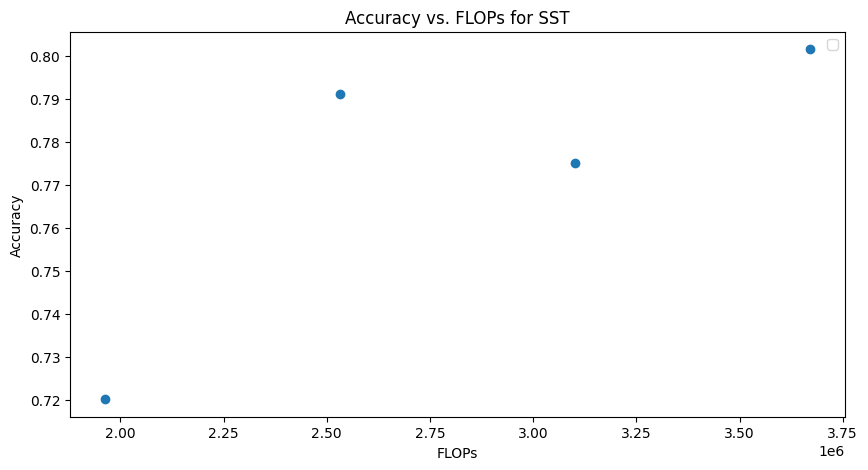

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

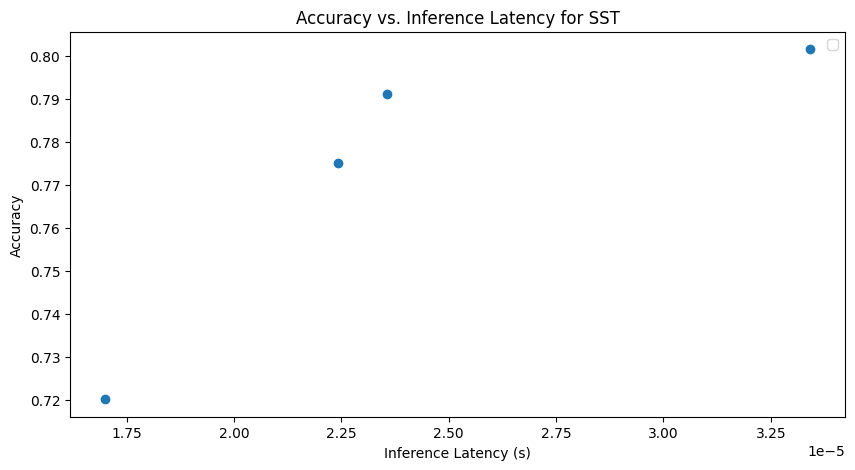

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

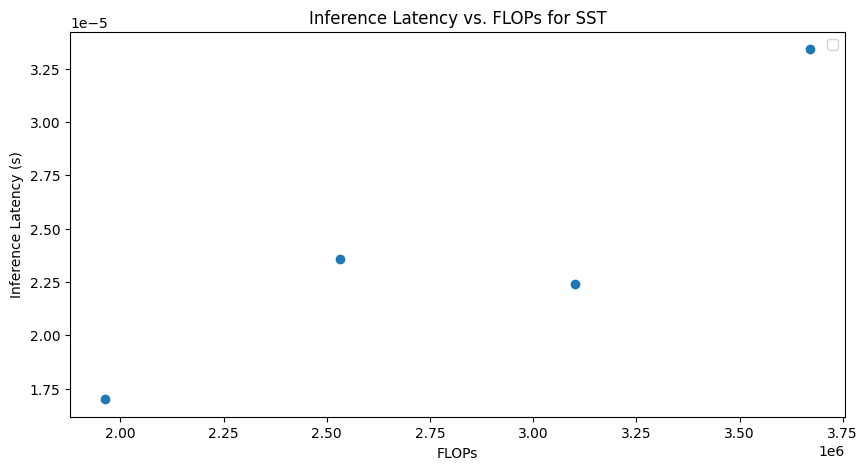

<Figure size 640x480 with 0 Axes>

In [49]:
plot_results(
    model_names=['SST'],
    accs=[exp10_sst_accs],
    flops=[exp10_sst_flops],
    latencies=[exp10_sst_latencies],
    exp=10
)

In [50]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincenthuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
# do the same thing for removing stopwords
sst_exp11_dataloaders = {}
sst_exp11_dataloaders[f'remove_stopwords-{True}'] = {'train': torch.utils.data.DataLoader(
    dataset=SSTDataset(data_dir='SST-2', data_type='train', remove_stopwords=True),
    batch_size=sst_config['batch_size'],
    shuffle=True
), 
'valid': torch.utils.data.DataLoader(
    dataset=SSTDataset(data_dir='SST-2', data_type='dev', vocab=sst_train_dataset.vocab, remove_stopwords=True),
    batch_size=sst_config['batch_size'],
    shuffle=False
)}

sst_exp11_dataloaders[f'remove_stopwords-{False}'] = {'train': torch.utils.data.DataLoader(
    dataset=SSTDataset(data_dir='SST-2', data_type='train', remove_stopwords=False),
    batch_size=sst_config['batch_size'],
    shuffle=True
),
'valid': torch.utils.data.DataLoader(
    dataset=SSTDataset(data_dir='SST-2', data_type='dev', vocab=sst_train_dataset.vocab, remove_stopwords=False),
    batch_size=sst_config['batch_size'],
    shuffle=False
)}

In [55]:
exp11_sst_config = sst_config.copy()
exp11_sst_config['epochs'] = 2
exp11_sst_config['input_size'] = len(sst_train_dataset.vocab)

exp11_sst_accs, exp11_sst_flops, exp11_sst_latencies = run_experiment10(exp11_sst_config, sst_exp11_dataloaders, sst_exp11_dataloaders.keys())

Training with top remove_stopwords-True vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7981651376146789


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7981651376146789
Validation Accuracy: 0.7981651376146789
Training with top remove_stopwords-False vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8084862385321101


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.8061926605504587
Validation Accuracy: 0.8061926605504587


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


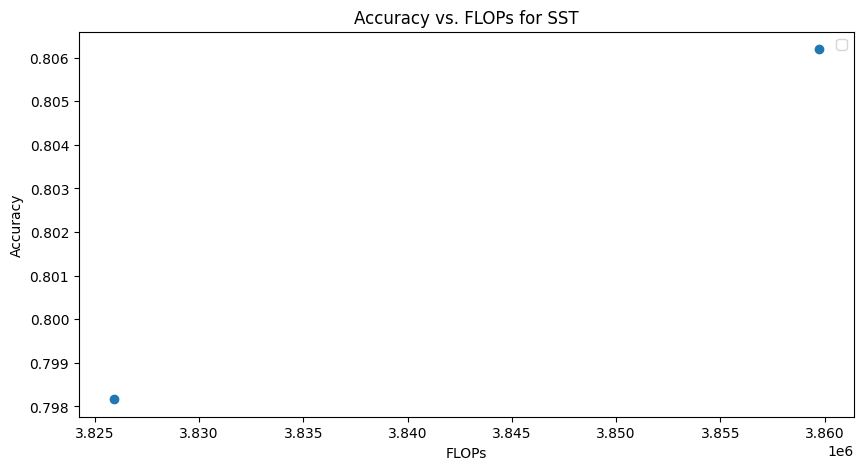

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

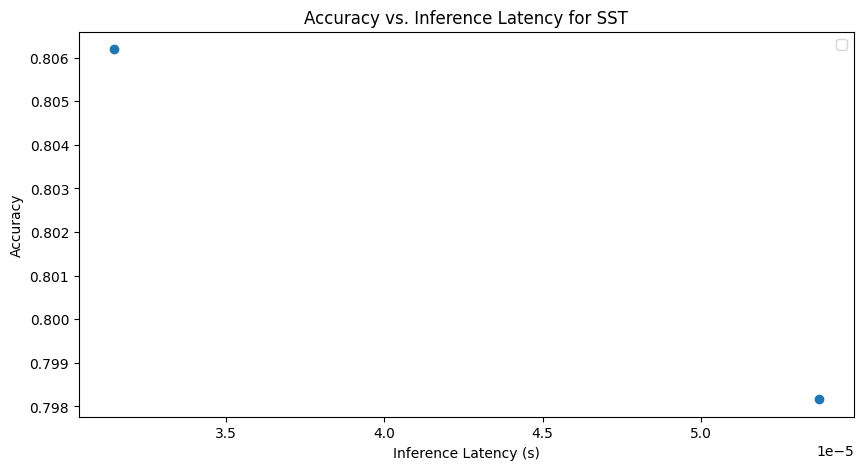

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

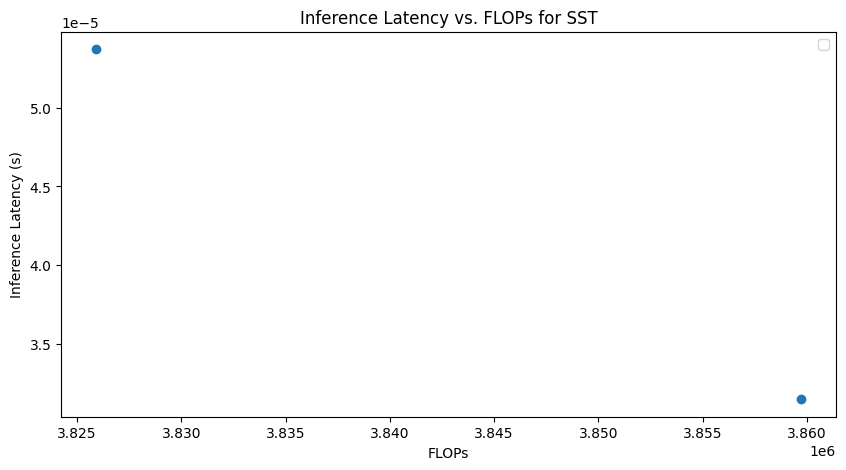

<Figure size 640x480 with 0 Axes>

In [56]:
plot_results(
    model_names=['SST'],
    accs=[exp11_sst_accs],
    flops=[exp11_sst_flops],
    latencies=[exp11_sst_latencies],
    exp=11
)

# Experiment 12: Combining

In [61]:
# for MNIST, use input size center cropped 20 * 20, and 1 hidden layer

mnist_exp12_dataloaders = {}
mnist_exp12_config = mnist_config.copy()
mnist_exp12_config['epochs'] = 3
mnist_exp12_config['input_size'] = 20 * 20
mnist_exp12_config['hidden_layers'] = 1
mnist_exp12_config['layer_size'] = 128
mnist_exp12_dataloaders['crop-20'] = {
    'train': torch.utils.data.DataLoader(
    dataset=MNISTDataset(data_dir='MNIST', data_type='train',
                         transforms=crop_transforms['crop-20']),
    batch_size=mnist_exp12_config['batch_size'],
    shuffle=True
),
    'valid': torch.utils.data.DataLoader(
        dataset=MNISTDataset(data_dir='MNIST', data_type='test',
                             transforms=crop_transforms['crop-20']),
        batch_size=mnist_exp12_config['batch_size'],
        shuffle=False
)}

exp12_crop_transforms = {
    'crop-20': transforms.CenterCrop((20, 20)),
}

mnist_exp12_accs, mnist_exp12_flops, mnist_exp12_latencies = run_experiment8(mnist_exp12_config, mnist_exp12_dataloaders, exp12_crop_transforms)

Training with transform crop-20


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.960996099609961


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.9683968396839684


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Accuracy: 0.972997299729973
Validation Accuracy: 0.972997299729973


In [62]:
# include baseline into the returned values
mnist_exp12_accs = [0.953] + mnist_exp12_accs
mnist_exp12_flops = [669729.21] + mnist_exp12_flops
mnist_exp12_latencies = [9.13e-6] + mnist_exp12_latencies

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


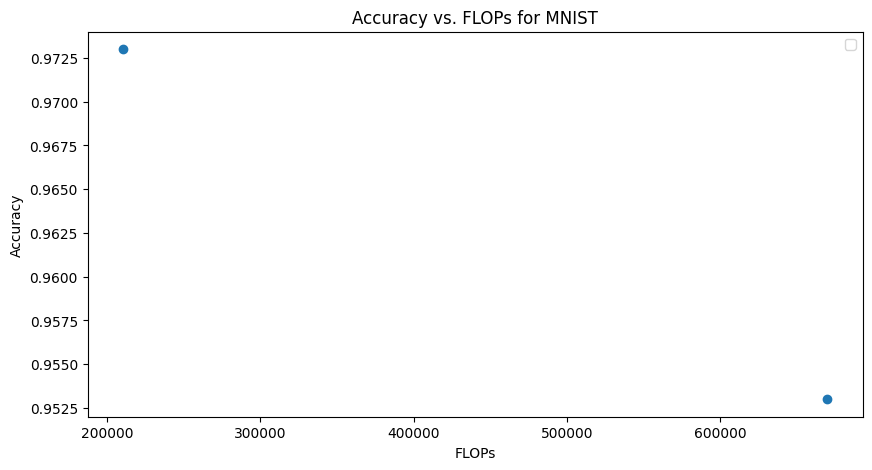

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

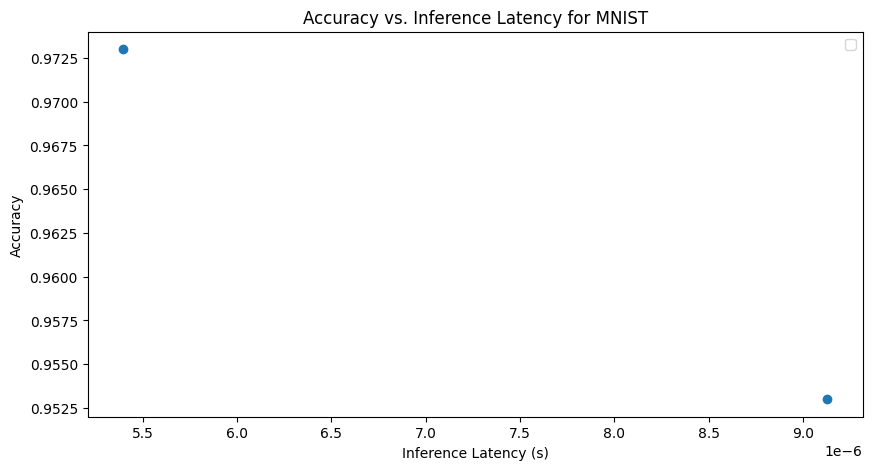

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

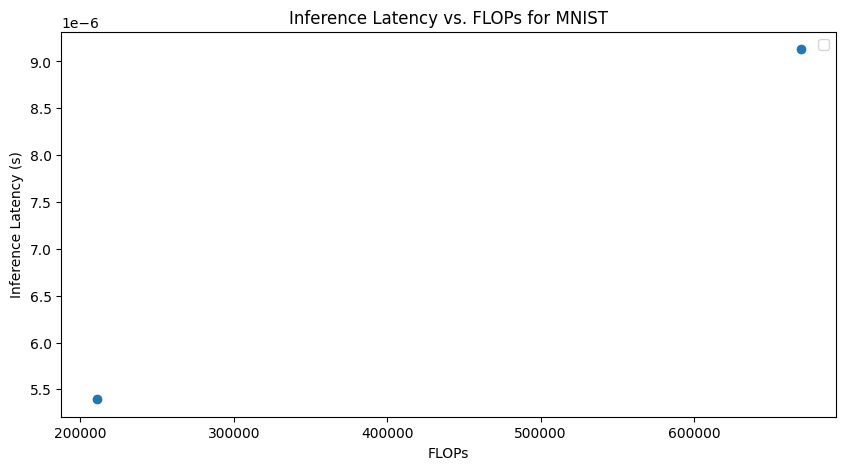

<Figure size 640x480 with 0 Axes>

In [63]:
plot_results(
    model_names=['MNIST'],
    accs=[mnist_exp12_accs],
    flops=[mnist_exp12_flops],
    latencies=[mnist_exp12_latencies],
    exp=12)

In [86]:
# for sst, use 4 layers, top 50% of vocab and width of 256
sst_exp12_dataloaders = {}
sst_exp12_config = sst_config.copy()
sst_exp12_config['epochs'] = 2
sst_exp12_config['input_size'] = int(len(sst_train_dataset.vocab) * 0.75)
sst_exp12_config['hidden_layers'] = 2
sst_exp12_config['layer_size'] = 128
exp12_train_ds = SSTDataset(data_dir='SST-2', data_type='train', top_k=int(len(sst_train_dataset.vocab)))
sst_exp12_dataloaders['top_k-0.5'] = {'train': torch.utils.data.DataLoader(
    dataset=exp12_train_ds,
    batch_size=sst_exp12_config['batch_size'],
    shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=SSTDataset(data_dir='SST-2', data_type='dev', vocab=exp12_train_ds.vocab),
        batch_size=sst_exp12_config['batch_size'],
        shuffle=False
    )}

sst_exp12_accs, sst_exp12_flops, sst_exp12_latencies = run_experiment10(sst_exp12_config, sst_exp12_dataloaders, sst_exp12_dataloaders.keys())

Training with top top_k-0.5 vocabulary


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7763761467889908


Train:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Accuracy: 0.7924311926605505
Validation Accuracy: 0.7924311926605505


In [83]:
sst_exp12_flops

[3959714, 3959714, 3859714.0]

In [87]:
sst_exp12_accs = [0.815] + [0.818]
sst_exp12_flops = [3859714] + [156000]
sst_exp12_latencies = [5.07e-5] + [3.05e-5]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


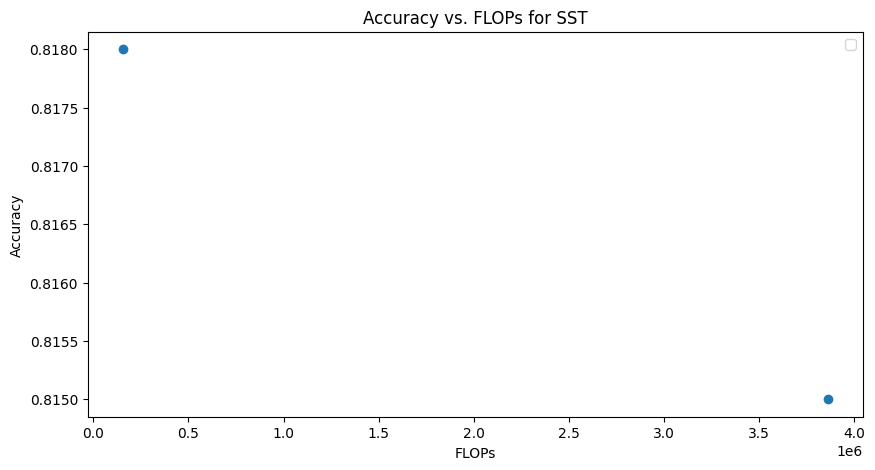

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

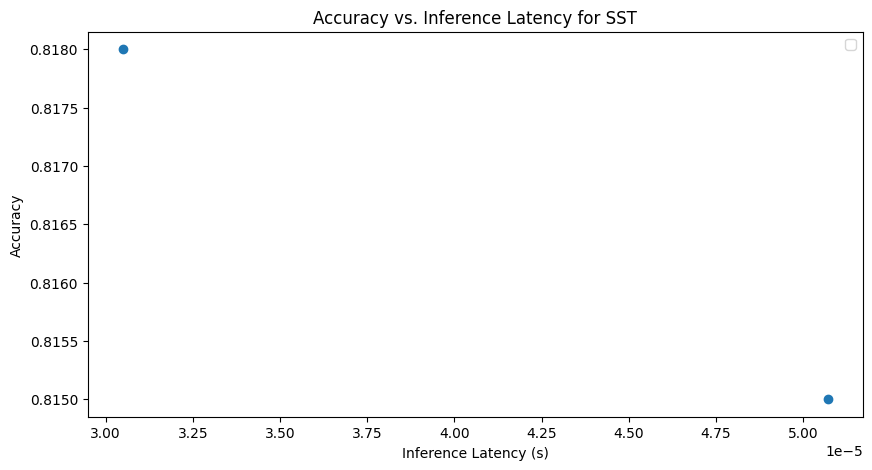

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

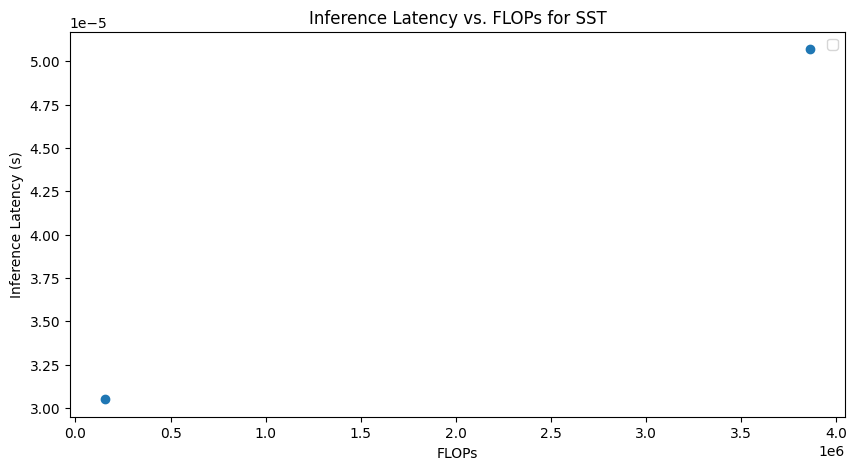

<Figure size 640x480 with 0 Axes>

In [88]:
plot_results(
    model_names=['SST'],
    accs=[sst_exp12_accs],
    flops=[sst_exp12_flops],
    latencies=[sst_exp12_latencies],
    exp=12)